<a href="https://colab.research.google.com/github/bloodclaw2000/Mala-Simulations/blob/main/mala_notebookv2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IF NEEDED INSTALL MALA (works in Colab). Install Pytorch from webpage instructions (not needed in COLAB)

You can also change runtime type to GPU in Runtime tab

In [1]:
import sys
sys.path.insert(0, '/usr/local/lib/python3.8/dist-packages/') #We need to upgrade Python Client for some reason COLAB is py 3.6

!python -m pip install --upgrade pip
!git clone https://github.com/mala-project/mala.git
%cd mala
!pip install -e .
%cd .

  Using cached pip-24.0-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Cloning into 'mala'...
remote: Enumerating objects: 21807, done.
remote: Counting objects: 100% (4112/4112), done.
remote: Compressing objects: 100% (1039/1039), done.
remote: Total 21807 (delta 3091), reused 3904 (delta 3051), pack-reused 17695
Receiving objects: 100% (21807/21807), 56.97 MiB | 30.15 MiB/s, done.
Resolving deltas: 100% (16247/16247), done.
/content/mala
Processing /content/mala
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 22.9 MB/s eta 0:0

In [2]:
%cd ..
%ls


/content
mala/  sample_data/


Downloading Original QE input data (or upload your own and unzip)

In [3]:
!git clone https://github.com/bloodclaw2000/Mala-Simulations.git
%cd Mala-Simulations


Cloning into 'Mala-Simulations'...
remote: Enumerating objects: 1608, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 1608 (delta 18), reused 39 (delta 17), pack-reused 1565
Receiving objects: 100% (1608/1608), 426.14 MiB | 21.91 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Updating files: 100% (1570/1570), done.
/content/Mala-Simulations


In [4]:
%cd ..
%ls

/content
mala/  Mala-Simulations/  sample_data/


Loading the modules

In [43]:
# MALA itself.

import mala

# We would like to visualize simple plots.
# The font size can sometimes be a bit small for Jupyter Notebooks.

import matplotlib
import matplotlib.pyplot as plt
font = {'size'   : 22}
matplotlib.rc('font', **font)

# For the data paths.
from os.path import join as pj

# Only for the prediction down below.
from ase.io import read

# To do some timings down below.
from time import time
import numpy as np
import mala
import subprocess
import ase
import ase.io.espresso
from ase import Atoms
from ase.visualize import view
import os
from os.path import join as pj
import matplotlib.pyplot as plt
import re
import random
import time

If problems with MALA, Check Pytorch Installation with

In [44]:
import torch

MALA data generation can be performed with the Quantum ESPRESSO package. Some changes to this open source package were necessary to enable the correct sampling of the LDOS. The current development branch of Quantum ESPRESSO includes those - beginning with Quantum ESPRESSO version 7.2 (to be released in ~June 2023) users can simply download the latest QE version and perform data generation.

Data generation is two-fold: First, one creates a set of atomic position via a regular DFT-MD simulation at the conditions of interest. This can be done with any suitable code, such as VASP, QE, etc. Secondly, one performs DFT simulations to access the LDOS.

The test system  here will be a simply beryllium system at room temperature consisting of 2 beryllium atoms. Atomic configurations have been sampled beforehand. We will start with the DFT simulation.

Write hundreds of lines of parameter statement in each python script is not exactly maintainable. Therefore MALA provides a .json interface.


In [45]:
parameters = mala.Parameters.load_from_file(r"/content/Mala-Simulations/mala_parameters_01.json")

In [46]:
parameters.show()

---     All parameter MALA needs to perform its various tasks. ---
comment        : My first parameters.
manual_seed    : None
use_gpu        : True
device         : cuda:0
use_horovod    : False
use_mpi        : False
verbosity      : 1
openpmd_configuration: {}
openpmd_granularity: 1
use_lammps     : True
---     Parameters necessary for constructing a neural network. ---
	nn_type        : feed-forward
	layer_sizes    : [10, 10, 10]
	layer_activations: ['Sigmoid']
	loss_function_type: mse
	num_hidden_layers: 1
	no_hidden_state: False
	bidirection    : False
	dropout        : 0.1
	num_heads      : 10
---     Parameters necessary for calculating/parsing input descriptors. ---
	descriptor_type: Bispectrum
	lammps_compute_file: 
	descriptors_contain_xyz: True
	use_z_splitting: True
	number_y_planes: 0
	bispectrum_twojmax: 10
	rcutfac        : 4.67637
	atomic_density_cutoff: 4.67637
	snap_switchflag: 1
	use_atomic_density_energy_formula: False
	atomic_density_sigma: None
	minterpy_point_l

In [47]:
data_path = r"/content/Mala-Simulations/original_QE_files/Data_Gen/Be"
snapshot_path =  r"/content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots"

We'll now convert the data to MALA DATA (maxiter must be the same as QE files)
THIS WILL TAKE LONG AS FUCK because no LAMMPS is compiled to work with MALA, be warned. There is a multiproccesing script in Github

In [48]:
data_converter = mala.DataConverter(parameters)
maxiter = 8
for i in range(1, maxiter):
    time1 = time.time()
    data_converter.add_snapshot(descriptor_input_type="espresso-out",
                                descriptor_input_path=os.path.join(data_path,f"Be{i}.pw.out"),
                                target_input_type=".cube",
                                target_input_path=os.path.join(f"tmp.pp0*Be{i}_ldos.cube"))
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")
print("CONVERTING SNAPSHOTS")
time1 = time.time()
#UNCOMMENT IF WANNA TRY HERE
#data_converter.convert_snapshots("./snapshots/", naming_scheme="Be_snapshot*.npy")


Disabling z-splitting for preprocessing.
DONE ADDING DATA ITERATION 1 of 7 in 0.00s
DONE ADDING DATA ITERATION 2 of 7 in 0.00s
DONE ADDING DATA ITERATION 3 of 7 in 0.00s
DONE ADDING DATA ITERATION 4 of 7 in 0.00s
DONE ADDING DATA ITERATION 5 of 7 in 0.00s
DONE ADDING DATA ITERATION 6 of 7 in 0.00s
DONE ADDING DATA ITERATION 7 of 7 in 0.00s
CONVERTING SNAPSHOTS


Visualizing and reproducing output data

Before we train a model, it is a good idea to think about which metric is important, i.e., how do we test if a model is good?

In essence, the advantage of MALA is the access to multiple observables. Two easily accesible metrics are the density of states (DOS) and the band energy. We will now see how to calculate them from the LDOS (the actual DFT LDOS in this case) so we can do the same after model training to test our models.

For this, we first have to make sure the correct LDOS parameters are used.


In [49]:
parameters.targets.target_type = "LDOS"
parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5

Now we can create an LDOS calculator and directly populate it with the LDOS data from the data set.

In [50]:
ldos_calculator = mala.LDOS.from_numpy_file(parameters, pj(snapshot_path, "Be_snapshot1.out.npy"))


Afterwards, we have to read in some additional information from the simulation data (size of the real space grid, temperature, etc.).

In [51]:
ldos_calculator.read_additional_calculation_data(pj(data_path, "Be1.pw.out"))
print(ldos_calculator.density_of_states)
print(ldos_calculator.energy_grid)
#print(ldos_calculator.density_of_states)

[0.30867848 0.40815389 0.50501234 0.58352213 0.63074861 0.63961693
 0.60908288 0.54389667 0.45474118 0.35631671 0.26284809]
[-5.  -2.5  0.   2.5  5.   7.5 10.  12.5 15.  17.5 20. ]


Now we can access the DOS and the band energy as properties of the calculator object.

-4.6133443142764


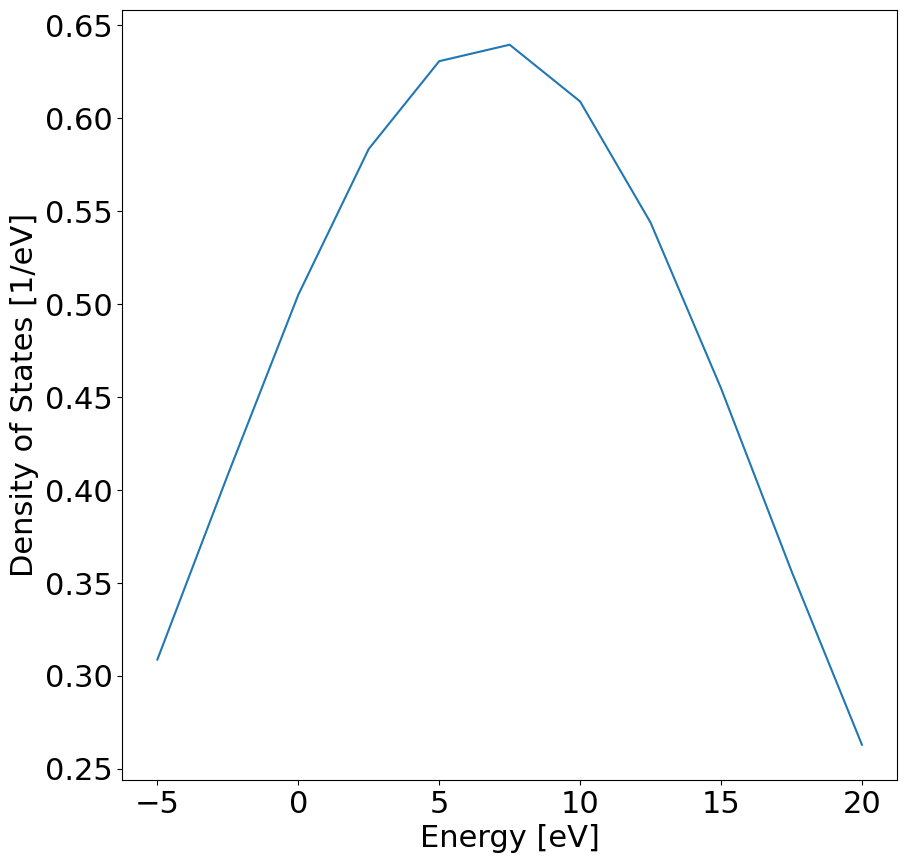

In [52]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states)

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")

print(ldos_calculator.band_energy)

In [53]:
parameters.verbosity = 2
parameters.manual_seed = 2024

Now we have to add data, we have to choose between training and test data

In [54]:

def split_data(maxiter, prop, prop2):
    data = np.arange (1,maxiter +1)
    random.shuffle(data)  # Shuffle the data randomly
    split_80 = int(len(data) * prop)  # Calculate the index for the 80% split
    split_20 = int(len(data) * prop2)  # Calculate the index for the 20% split
    train_data = data[:split_80]  # Extract the first 80% of the shuffled data
    test_data = data[split_80:split_80+split_20 ]  # Extract the next 20% of the shuffled data
    validation_data = data[split_80+split_20:]  # Extract the remaining 20% of the shuffled data
    return train_data, test_data, validation_data



We'll now test in a very basic system, a 2 atom Si, where we only change Atomic Positions in a +-0.1 crystallographic axes randomly
Akin to a relax calculation in QE

In [55]:
data_path = r"/content/Mala-Simulations/original_QE_files/Data_Gen/SiPositions"
snapshot_path =  r"/content/Mala-Simulations/original_QE_files/Data_Gen/SiPositions/snapshots"

In [56]:
parameters.targets.target_type = "LDOS"
parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5
ldos_calculator = mala.LDOS.from_numpy_file(parameters, pj(snapshot_path, "Si_snapshot1.out.npy"))
ldos_calculator.read_additional_calculation_data(pj(data_path, "Si1.pw.out"))
print(ldos_calculator.density_of_states)
print(ldos_calculator.energy_grid)
#print(ldos_calculator.density_of_states)

[0.46287329 0.6115053  0.76945438 0.92349997 1.05818843 1.15674994
 1.20294891 1.18431658 1.09682349 0.94970734 0.76641084]
[-5.  -2.5  0.   2.5  5.   7.5 10.  12.5 15.  17.5 20. ]


Let's plot the DOS

0.49882503261697764


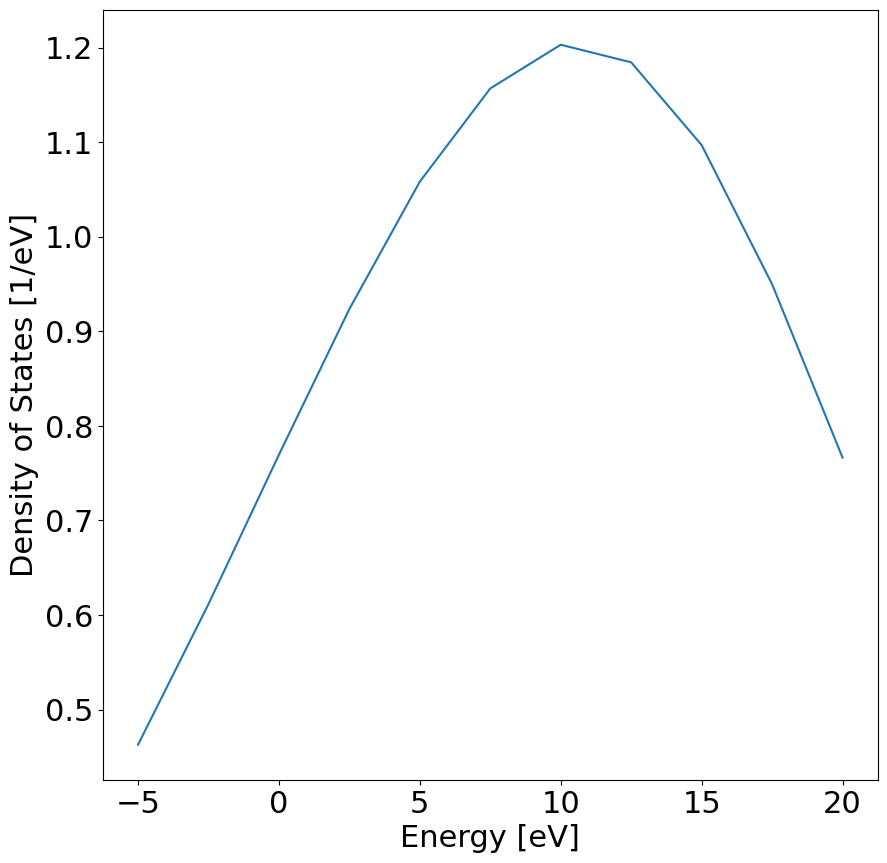

In [57]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states)

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")

print(ldos_calculator.band_energy)

Now we'll Load all the Si Files, and split data (watch out for number of snapshots and props)

In [58]:
parameters = mala.Parameters.load_from_file(r"/content/Mala-Simulations/mala_parameters_01.json")
data_handler = mala.DataHandler(parameters)
prop = 0.7 # proportion of training data
prop2 = 0.2 #proportion of validation data
maxiter = 12 # number of .in snapshots
train_data, test_data, validation_data = split_data(maxiter, prop, prop2)
print(train_data, test_data, validation_data)
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "va")

    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()


No data rescaling will be performed.
No data rescaling will be performed.
[10  4  5  9  1  3  8 12] [2 7] [11  6]
DONE ADDING DATA ITERATION 1 of 11 in 0.00s
DONE ADDING DATA ITERATION 2 of 11 in 0.00s
DONE ADDING DATA ITERATION 3 of 11 in 0.00s
DONE ADDING DATA ITERATION 4 of 11 in 0.00s
DONE ADDING DATA ITERATION 5 of 11 in 0.00s
DONE ADDING DATA ITERATION 6 of 11 in 0.00s
DONE ADDING DATA ITERATION 7 of 11 in 0.00s
DONE ADDING DATA ITERATION 8 of 11 in 0.00s
DONE ADDING DATA ITERATION 9 of 11 in 0.00s
DONE ADDING DATA ITERATION 10 of 11 in 0.00s
DONE ADDING DATA ITERATION 11 of 11 in 0.00s
DONE ADDING DATA ITERATION 12 of 11 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot1.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/SiPositions/snapshots
Checking targets file  Si_snapshot1.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/SiPositions/snapshots
Checking descriptor file  Si_snapshot3.in.npy at /con

Now we  can train the Network. It is a basic Network with 100 neurons. Takes about 3-4 minutes. Much faster if GPU

In [59]:
parameters.verbosity = 2
parameters.use_gpu = True #if crashing or error just delete below parameters, set gpu to false and rerun cell above. First error just run cell above
#parameters.running.use_graphs = True  #NVIDIA things. Pretty Buggy but performant when it wants to
parameters.data.use_fast_tensor_data_set = True #Watch out if AMD

parameters.network.layer_sizes = [data_handler.input_dimension,
                                  100, data_handler.output_dimension]
parameters.running.max_number_epochs = 2
parameters.running.early_stopping_epochs = 10
network = mala.Network(parameters)
time1 = time.time()
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()
print(f"DONE Training Model in {time.time() - time1:.2f}s")

batch 1000, validation avg time: 0.00046893668174743654 validation avg throughput: 21324.840621843006
batch 2000, validation avg time: 0.00046335220336914064 validation avg throughput: 21581.854855308113
batch 3000, validation avg time: 0.00044339442253112793 validation avg throughput: 22553.283243651906
batch 4000, validation avg time: 0.00045567154884338377 validation avg throughput: 21945.63172834177
Initial Guess - validation data loss:  0.23060443109348633
batch 1000, train avg time: 0.0011866993904113769 train avg throughput: 8426.733914924685
batch 2000, train avg time: 0.001181427001953125 train avg throughput: 8464.340144137628
batch 3000, train avg time: 0.0011628875732421875 train avg throughput: 8599.283567988872
batch 4000, train avg time: 0.001162219524383545 train avg throughput: 8604.22647374137
batch 5000, train avg time: 0.0011495804786682128 train avg throughput: 8698.825515535009
batch 6000, train avg time: 0.0013614223003387451 train avg throughput: 7345.2594375101

We can test this by using the Tester class. The class works similar to the Trainer class. We add data, push them through the model, and then use the results to perform calculations.

We just have to make sure that the LDOS is correctly integrated by setting the appropriate parameters. Then we can add data to test. We should always test on data different from the one we trained on. Also, we now have to specify the corresponding calculation output, since we may need this for integration.

In [60]:
data_handler.clear_data()
parameters.targets.target_type = "LDOS"
parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5

for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))


data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()


Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot2.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/SiPositions/snapshots
Checking targets file  Si_snapshot2.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/SiPositions/snapshots
Checking descriptor file  Si_snapshot7.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/SiPositions/snapshots
Checking targets file  Si_snapshot7.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/SiPositions/snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.
Had to readjust batch size from 10 to 12


Results are given in error of ev/atom

In [61]:
results

{'band_energy': [1.3924770341843171, 0.5309703771867476]}

Let's do the Same with a much bigger network, for better results

In [62]:
parameters = mala.Parameters.load_from_file(r"/content/Mala-Simulations/mala_parameters_01.json")

data_handler = mala.DataHandler(parameters)
prop = 0.8 # proportion of training data
prop2 = 0.1 #proportion of validation data
maxiter = 12 # number of .in snapshots
train_data, test_data, validation_data = split_data(maxiter, prop, prop2)
print(train_data, test_data, validation_data)
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "va")

    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()


No data rescaling will be performed.
No data rescaling will be performed.
[11 12  3  6  1  9 10  5  7] [8] [4 2]
DONE ADDING DATA ITERATION 1 of 11 in 0.00s
DONE ADDING DATA ITERATION 2 of 11 in 0.00s
DONE ADDING DATA ITERATION 3 of 11 in 0.00s
DONE ADDING DATA ITERATION 4 of 11 in 0.00s
DONE ADDING DATA ITERATION 5 of 11 in 0.00s
DONE ADDING DATA ITERATION 6 of 11 in 0.00s
DONE ADDING DATA ITERATION 7 of 11 in 0.00s
DONE ADDING DATA ITERATION 8 of 11 in 0.00s
DONE ADDING DATA ITERATION 9 of 11 in 0.00s
DONE ADDING DATA ITERATION 10 of 11 in 0.00s
DONE ADDING DATA ITERATION 11 of 11 in 0.00s
DONE ADDING DATA ITERATION 12 of 11 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot1.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/SiPositions/snapshots
Checking targets file  Si_snapshot1.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/SiPositions/snapshots
Checking descriptor file  Si_snapshot2.in.npy at /cont

We'll also rescale all descriptors with Row Standardization to improve performance

In [63]:
parameters.use_gpu = True #if crashing or error just delete below parameters, set gpu to false and rerun cell above. First error just run cell above
#parameters.running.use_graphs = True  #NVIDIA things. Pretty Buggy but performant when it wants to
parameters.data.use_fast_tensor_data_set = True #Watch out if AMD
parameters.running.learning_rate = 0.5
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  500,data_handler.output_dimension]
parameters.data.input_rescaling_type = "feature-wise-standard"
parameters.running.max_number_epochs = 10
parameters.running.early_stopping_epochs = 4
network = mala.Network(parameters)
time1 = time.time()
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()
print(f"DONE Training Model in {time.time() - time1:.2f}s")

Initial Guess - validation data loss:  0.18673145437654443
Epoch 0: validation data loss: 6.518767214413434e-06
Epoch 1: validation data loss: 3.360876213604712e-06
Epoch 2: validation data loss: 2.4487458891527174e-06
Epoch 3: validation data loss: 1.9348819229101608e-06
Epoch 4: validation data loss: 1.657672905387391e-06
Epoch 5: validation data loss: 1.4843703440696777e-06
Epoch 6: validation data loss: 1.3667085812415427e-06
Epoch 7: validation data loss: 1.2316231381439082e-06
Epoch 8: validation data loss: 1.1345824916472545e-06
Epoch 9: validation data loss: 1.0631815058860852e-06
Final validation data loss:  1.0631815058860852e-06
DONE Training Model in 251.46s


In [64]:
data_handler.clear_data()
for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))


data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()
results

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot8.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/SiPositions/snapshots
Checking targets file  Si_snapshot8.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/SiPositions/snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.
Had to readjust batch size from 10 to 12


{'band_energy': [-0.3507957762563976]}

Let's save the data and then calculate DOS from it

In [65]:
trainer.save_run("Si1_model")

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot8.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/SiPositions/snapshots
Checking targets file  Si_snapshot8.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/SiPositions/snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


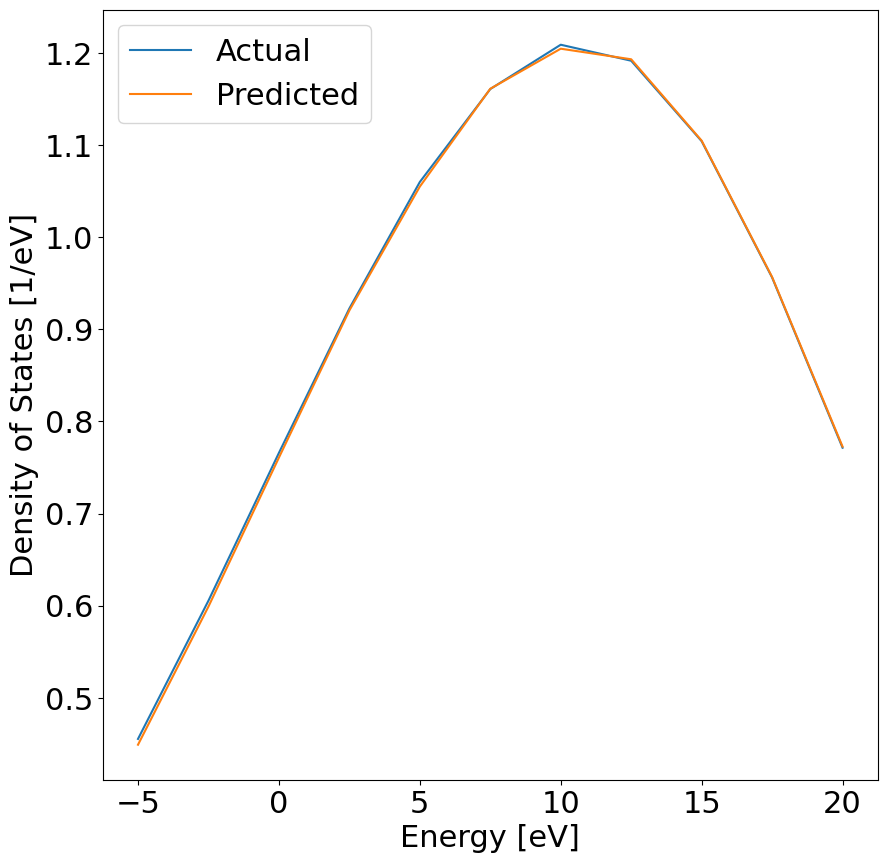

In [66]:
parameters, network, data_handler, tester = mala.Tester.load_run("Si1_model")
data_handler.clear_data()
data_handler.add_snapshot(f"Si_snapshot{test_data[0]}.in.npy", snapshot_path,
                              f"Si_snapshot{test_data[0]}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{test_data[0]}.pw.out"))
data_handler.prepare_data(reparametrize_scaler=False)
actual_ldos, predicted_ldos = tester.predict_targets(0)
ldos_calculator = data_handler.target_calculator
ldos_calculator.read_additional_calculation_data(data_handler.get_snapshot_calculation_output(0))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ldos_calculator.read_from_array(actual_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Actual")
ldos_calculator.read_from_array(predicted_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Predicted")

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")
ax.legend()


Let's Show now how we can optimize network Parameters automatically. There are multiple algorithms implemented, but we will focus on the `optuna` library, to which MALA provides an interface. The idea is easy: we give MALA a set of hyperparameters to optimize, fix the others, give it some data and let optuna do its work. Optuna internally uses elaborate algorithms to determine optimal hyperparameters from observed data.

Kinda works, takes too long and buggy (still in development it seems), decided not to push this part Go after hyperparameter opt for Be and Si Cell parameters

In [67]:
"""
parameters.verbosity = 2
parameters.manual_seed = 2024
parameters.data.input_rescaling_type = "feature-wise-standard"
parameters.data.output_rescaling_type = "normal"
parameters.running.max_number_epochs = 100
parameters.running.mini_batch_size = 40
parameters.running.trainingtype = "SGD"
"""

'\nparameters.verbosity = 2\nparameters.manual_seed = 2024\nparameters.data.input_rescaling_type = "feature-wise-standard"\nparameters.data.output_rescaling_type = "normal"\nparameters.running.max_number_epochs = 100\nparameters.running.mini_batch_size = 40\nparameters.running.trainingtype = "SGD"\n'

Let's specify data to be used.


In [68]:
"""
data_handler = mala.DataHandler(parameters)
data_handler.clear_data()
train_data, test_data, validation_data = split_data(maxiter, prop, prop2)
print(train_data, test_data, validation_data)
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "va")
    else:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()
"""

'\ndata_handler = mala.DataHandler(parameters)\ndata_handler.clear_data()\ntrain_data, test_data, validation_data = split_data(maxiter, prop, prop2)\nprint(train_data, test_data, validation_data)\nfor i in range(1, maxiter + 1):\n    time1 = time.time()\n    if i in train_data:\n        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,\n                              f"Si_snapshot{i}.out.npy", snapshot_path, "tr")\n    elif i in validation_data :\n        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,\n                              f"Si_snapshot{i}.out.npy", snapshot_path, "va")\n    else:\n        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,\n                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",\n                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))\n    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")\n\n# This already loads data

Before we instantiate the hyperparameter optimizer, two important parameters to set are

1. The number of trials (test networks) to train
2. How often to train a test network - if we train each proposed network a number of times and evaluate the average performant, we can discard unrobust outliers. In the interest of time, let's keep it at 1 here.


In [69]:
"""parameters = mala.Parameters()
parameters.use_gpu = True #if crashing or error just delete these parameters
#parallelizes surprisingly good in cpu
parameters.data.use_fast_tensor_data_set = True #Watch out if AMD

parameters.running.max_number_epochs = 30
parameters.hyperparameters.n_trials = 3
parameters.hyperparameters.number_training_per_trial = 1
#parameters.running.after_before_training_metric = "band_energy"
hyperoptimizer = mala.HyperOptOptuna(parameters, data_handler)

hyperoptimizer.add_hyperparameter("categorical", "learning_rate",
                                     choices=[0.1, 0.2])
hyperoptimizer.add_hyperparameter("categorical", "ff_neurons_layer_00", choices=[10, 100, 200])
hyperoptimizer.add_hyperparameter("categorical", "ff_neurons_layer_01", choices=[10, 100, 200])
hyperoptimizer.add_hyperparameter("categorical", "early_stopping_epochs", choices=[4, 8])

# Choices for activation function at each layer will be optimized.
hyperoptimizer.add_hyperparameter("categorical", "trainingtype",
                                  choices=["SGD", "Adam"])

hyperoptimizer.add_hyperparameter("categorical", "layer_activation_00",
                                  choices=["ReLU", "Sigmoid", "LeakyReLU"])
"""

'parameters = mala.Parameters()\nparameters.use_gpu = True #if crashing or error just delete these parameters\n#parallelizes surprisingly good in cpu\nparameters.data.use_fast_tensor_data_set = True #Watch out if AMD \n\nparameters.running.max_number_epochs = 30\nparameters.hyperparameters.n_trials = 3\nparameters.hyperparameters.number_training_per_trial = 1\n#parameters.running.after_before_training_metric = "band_energy"\nhyperoptimizer = mala.HyperOptOptuna(parameters, data_handler)\n\nhyperoptimizer.add_hyperparameter("categorical", "learning_rate",\n                                     choices=[0.1, 0.2])\nhyperoptimizer.add_hyperparameter("categorical", "ff_neurons_layer_00", choices=[10, 100, 200])\nhyperoptimizer.add_hyperparameter("categorical", "ff_neurons_layer_01", choices=[10, 100, 200])\nhyperoptimizer.add_hyperparameter("categorical", "early_stopping_epochs", choices=[4, 8])\n\n# Choices for activation function at each layer will be optimized.\nhyperoptimizer.add_hyperp

The syntax is weird , since we are trying to cramp a complicated system into a few function calls. Now let's run it. This may take a while. Make a coffee while it runs.
Here, we have added the learning rate, number of neurons for two hidden NN layers and the activation function in between to the hyperparameter optimization

Learning rate of NN optimization (step size of gradient based optimizer)
Number of neurons per layer. This is the primary tuning parameter to optimize the network architecture
Optimization algorithm used during the NN optimization.
Describes the activation functions used in the NN.

In [70]:
"""hyperoptimizer.perform_study()

# Will save the results directly to the parameters.
hyperoptimizer.set_optimal_parameters()"""

'hyperoptimizer.perform_study()\n\n# Will save the results directly to the parameters.\nhyperoptimizer.set_optimal_parameters()'

Let's train the best network one final time and see where we stand. In my case, the network that Optuna suggest is bigger and deeper then the one we have used before, but that may differ. Keep in mind we are performing a very  limited search here in the interest of time.

In [71]:
"""data_handler.clear_data()
train_data, test_data, validation_data = split_data(maxiter, prop, prop2)
print(train_data, test_data, validation_data)
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "va")


    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()"""


'data_handler.clear_data()\ntrain_data, test_data, validation_data = split_data(maxiter, prop, prop2)\nprint(train_data, test_data, validation_data)\nfor i in range(1, maxiter + 1):\n    time1 = time.time()\n    if i in train_data:\n        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,\n                              f"Si_snapshot{i}.out.npy", snapshot_path, "tr")\n    elif i in validation_data :\n        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,\n                              f"Si_snapshot{i}.out.npy", snapshot_path, "va")\n    \n        \n    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")\n\n# This already loads data into RAM!\ndata_handler.prepare_data()'

In [72]:
"""network = mala.Network(parameters)

trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()

parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5
"""


'network = mala.Network(parameters)\n\ntrainer = mala.Trainer(parameters, network, data_handler)\ntrainer.train_network()\n\nparameters.targets.ldos_gridsize = 11\nparameters.targets.ldos_gridspacing_ev = 2.5\nparameters.targets.ldos_gridoffset_ev = -5\n'

In [73]:
"""data_handler.clear_data()
for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))


data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()

print("Energy Errors eV/atom", results)"""

'data_handler.clear_data()\nfor i in range(1, maxiter + 1):\n    if i in test_data:\n        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,\n                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",\n                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))\n\n\ndata_handler.prepare_data(reparametrize_scaler=False)\ntester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])\n\nresults = tester.test_all_snapshots()\n\nprint("Energy Errors eV/atom", results)'

In [74]:
parameters = mala.Parameters.load_from_file(r"/content/Mala-Simulations/mala_parameters_01.json")

Now we'll Load the Berillium Files, and split data (watch out for number of snapshots and props)

In [75]:
data_path = r"/content/Mala-Simulations/original_QE_files/Data_Gen/Be"
snapshot_path =  r"/content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots"

In [76]:
data_handler = mala.DataHandler(parameters)
prop = 0.6 # proportion of training data
prop2 = 0.3 #proportion of validation data
maxiter = 8 # number of .in snapshots
train_data, test_data, validation_data = split_data(maxiter, prop, prop2)
print(train_data, test_data, validation_data )
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "va")

    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  100,
                                  data_handler.output_dimension]

No data rescaling will be performed.
No data rescaling will be performed.
[6 8 2 7] [5 1] [4 3]
DONE ADDING DATA ITERATION 1 of 7 in 0.00s
DONE ADDING DATA ITERATION 2 of 7 in 0.00s
DONE ADDING DATA ITERATION 3 of 7 in 0.00s
DONE ADDING DATA ITERATION 4 of 7 in 0.00s
DONE ADDING DATA ITERATION 5 of 7 in 0.00s
DONE ADDING DATA ITERATION 6 of 7 in 0.00s
DONE ADDING DATA ITERATION 7 of 7 in 0.00s
DONE ADDING DATA ITERATION 8 of 7 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot2.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking targets file  Be_snapshot2.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking descriptor file  Be_snapshot3.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking targets file  Be_snapshot3.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking descriptor file  Be_snapshot4.in.npy at

Now we  can train the Network

In [77]:
parameters.running.max_number_epochs = 10
time1 = time.time()
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()
print(f"DONE Training Model in {time.time() - time1:.2f}s")

Initial Guess - validation data loss:  0.2651830008370536
Epoch 0: validation data loss: 1.996304520538875e-05
Epoch 1: validation data loss: 2.0295822194644383e-05
Epoch 2: validation data loss: 2.049125305243901e-05
Epoch 3: validation data loss: 2.0176847066198076e-05
Epoch 4: validation data loss: 2.0106479525566102e-05
Epoch 5: validation data loss: 1.981315016746521e-05
Epoch 6: validation data loss: 2.0148654069219316e-05
Epoch 7: validation data loss: 1.9996404647827147e-05
Epoch 8: validation data loss: 1.9015895468848093e-05
Epoch 9: validation data loss: 1.8944001623562403e-05
Final validation data loss:  1.8944001623562403e-05
DONE Training Model in 55.25s


We can test this by using the Tester class. The class works similar to the Trainer class. We add data, push them through the model, and then use the results to perform calculations.

We just have to make sure that the LDOS is correctly integrated by setting the appropriate parameters. Then we can add data to test. We should always test on data different from the one we trained on. Also, we now have to specify the corresponding calculation output, since we may need this for integration.

In [78]:
data_handler.clear_data()
for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Be{i}.pw.out"))


data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()


Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot1.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking targets file  Be_snapshot1.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking descriptor file  Be_snapshot5.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking targets file  Be_snapshot5.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


The results are given as a dictionary and in the units of meV/atom.The results are given as a dictionary and in the units of meV/atom.

In [79]:
results

{'band_energy': [0.1059644949039722, -0.08880593099079803]}

In [80]:
trainer.save_run("Be1_model")

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot5.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking targets file  Be_snapshot5.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


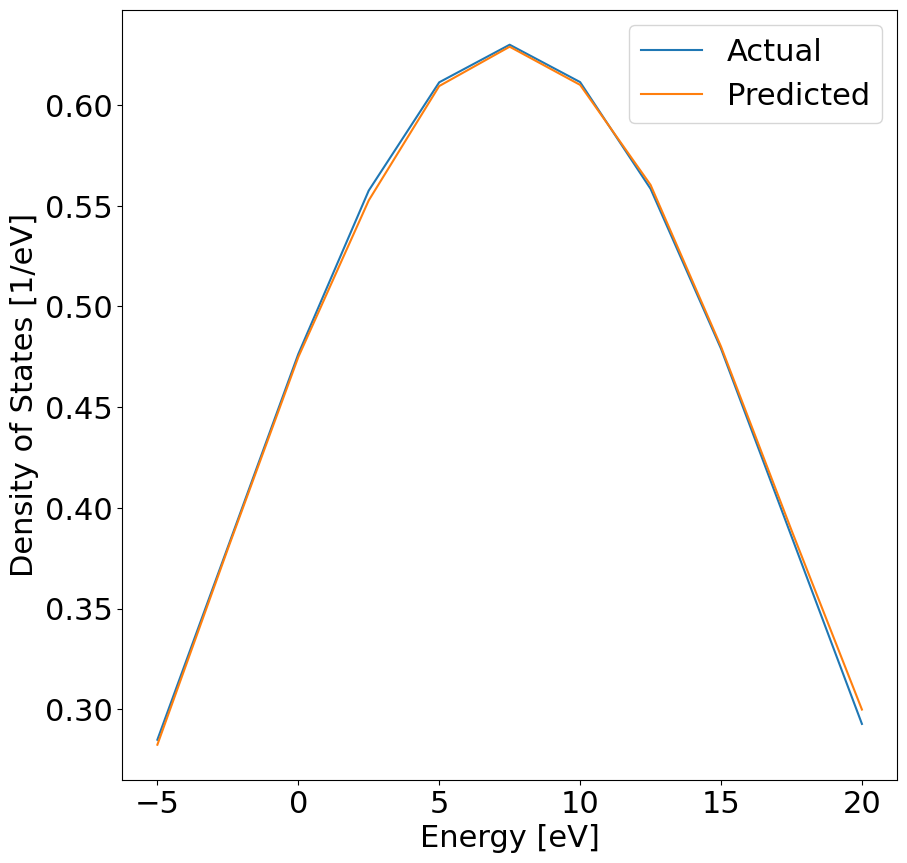

In [82]:
parameters, network, data_handler, tester = mala.Tester.load_run("Be1_model")
data_handler.clear_data()
data_handler.add_snapshot(f"Be_snapshot{test_data[0]}.in.npy", snapshot_path,
                              f"Be_snapshot{test_data[0]}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Be{test_data[0]}.pw.out"))
data_handler.prepare_data(reparametrize_scaler=False)
actual_ldos, predicted_ldos = tester.predict_targets(0)
ldos_calculator = data_handler.target_calculator
ldos_calculator.read_additional_calculation_data(data_handler.get_snapshot_calculation_output(0))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ldos_calculator.read_from_array(actual_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Actual")
ldos_calculator.read_from_array(predicted_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Predicted")

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")
ax.legend()


IMPROVE NN

In [83]:
parameters = mala.Parameters.load_from_file(r"/content/Mala-Simulations/mala_parameters_01.json")

In [84]:
data_handler = mala.DataHandler(parameters)
prop = 0.6 # proportion of training data
prop2 = 0.3 #proportion of validation data
maxiter = 8 # number of .in snapshots
train_data, test_data, validation_data = split_data(maxiter, prop, prop2)
print(train_data, test_data, validation_data )
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "va")

    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
#parameters.data.input_rescaling_type = "feature-wise-standard"
data_handler.prepare_data()
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  100,100,
                                  data_handler.output_dimension]


No data rescaling will be performed.
No data rescaling will be performed.
[3 4 8 2] [5 1] [7 6]
DONE ADDING DATA ITERATION 1 of 7 in 0.00s
DONE ADDING DATA ITERATION 2 of 7 in 0.00s
DONE ADDING DATA ITERATION 3 of 7 in 0.00s
DONE ADDING DATA ITERATION 4 of 7 in 0.00s
DONE ADDING DATA ITERATION 5 of 7 in 0.00s
DONE ADDING DATA ITERATION 6 of 7 in 0.00s
DONE ADDING DATA ITERATION 7 of 7 in 0.00s
DONE ADDING DATA ITERATION 8 of 7 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot2.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking targets file  Be_snapshot2.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking descriptor file  Be_snapshot3.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking targets file  Be_snapshot3.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking descriptor file  Be_snapshot4.in.npy at

In [85]:
parameters.running.max_number_epochs = 10
parameters.running.early_stopping_epochs = 4

network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
time1 = time.time()
trainer.train_network()
print(f"DONE Training Model in {time.time() - time1:.2f}s")

Initial Guess - validation data loss:  0.196006275088192
Epoch 0: validation data loss: 2.0492378204786655e-05
Epoch 1: validation data loss: 2.0192239209646526e-05
Epoch 2: validation data loss: 1.9934312775771424e-05
Epoch 3: validation data loss: 1.9705113634652684e-05
Epoch 4: validation data loss: 1.9594663920503212e-05
Epoch 5: validation data loss: 1.9699093065328964e-05
Validation accuracy has not improved enough.
Epoch 6: validation data loss: 1.9397366737506165e-05
Epoch 7: validation data loss: 1.875853491720149e-05
Epoch 8: validation data loss: 1.8369128123837416e-05
Epoch 9: validation data loss: 1.8154805940618756e-05
Final validation data loss:  1.8154805940618756e-05
DONE Training Model in 63.44s


In [86]:
data_handler.clear_data()
for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Be{i}.pw.out"))


data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()
results

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot1.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking targets file  Be_snapshot1.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking descriptor file  Be_snapshot5.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking targets file  Be_snapshot5.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


{'band_energy': [0.17132824371715571, -0.0603397427352661]}

Now Save Data

In [87]:
trainer.save_run("Be2_model")

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot5.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
Checking targets file  Be_snapshot5.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Be/snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


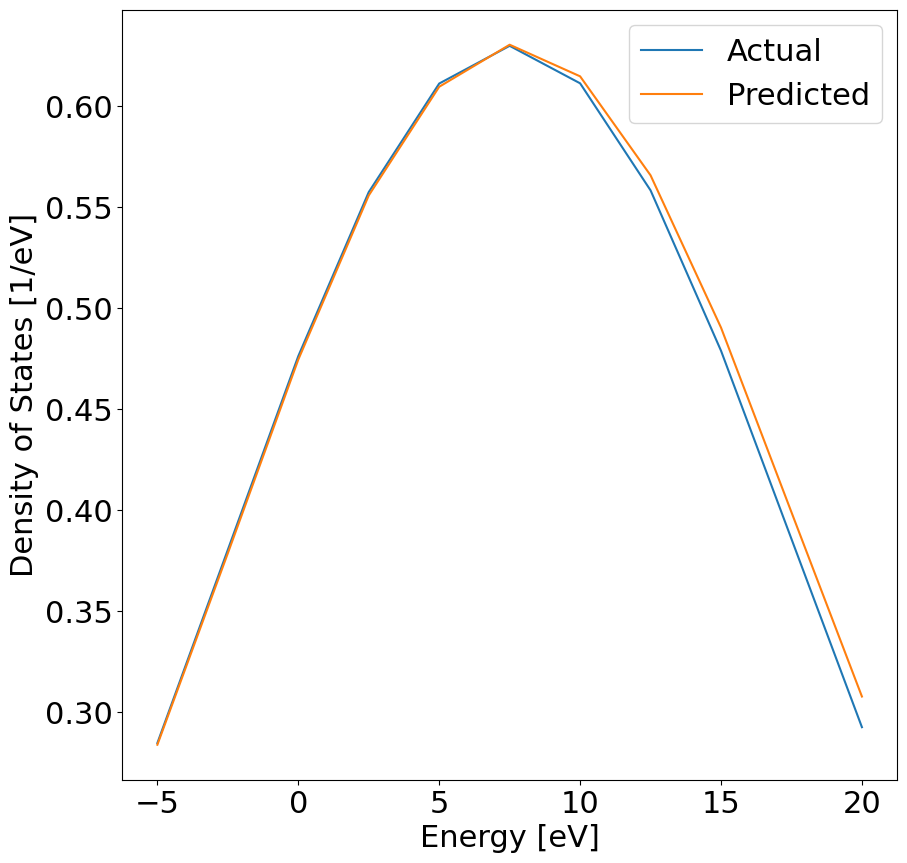

In [89]:
parameters, network, data_handler, tester = mala.Tester.load_run("Be2_model")
data_handler.clear_data()
data_handler.add_snapshot(f"Be_snapshot{test_data[0]}.in.npy", snapshot_path,
                              f"Be_snapshot{test_data[0]}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Be{test_data[0]}.pw.out"))
data_handler.prepare_data(reparametrize_scaler=False)
actual_ldos, predicted_ldos = tester.predict_targets(0)
ldos_calculator = data_handler.target_calculator
ldos_calculator.read_additional_calculation_data(data_handler.get_snapshot_calculation_output(0))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ldos_calculator.read_from_array(actual_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Actual")
ldos_calculator.read_from_array(predicted_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Predicted")

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")
ax.legend()


Let's work now in another material

In [90]:
parameters = mala.Parameters.load_from_file(r"/content/Mala-Simulations/mala_parameters_01.json")

In [91]:
data_path = r"/content/Mala-Simulations/original_QE_files/Data_Gen/Si"
snapshot_path =  r"/content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots"

In [92]:
parameters.targets.target_type = "LDOS"
parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5
ldos_calculator = mala.LDOS.from_numpy_file(parameters, pj(snapshot_path, "Si_snapshot1.out.npy"))
ldos_calculator.read_additional_calculation_data(pj(data_path, "Si1.pw.out"))
print(ldos_calculator.density_of_states)
print(ldos_calculator.energy_grid)
#print(ldos_calculator.density_of_states)

[0.3503686  0.48364223 0.63366231 0.78783649 0.93219551 1.05337473
 1.13872125 1.17598408 1.15475547 1.0707479  0.93120694]
[-5.  -2.5  0.   2.5  5.   7.5 10.  12.5 15.  17.5 20. ]


Let's plot the DOS

9.10873650880503


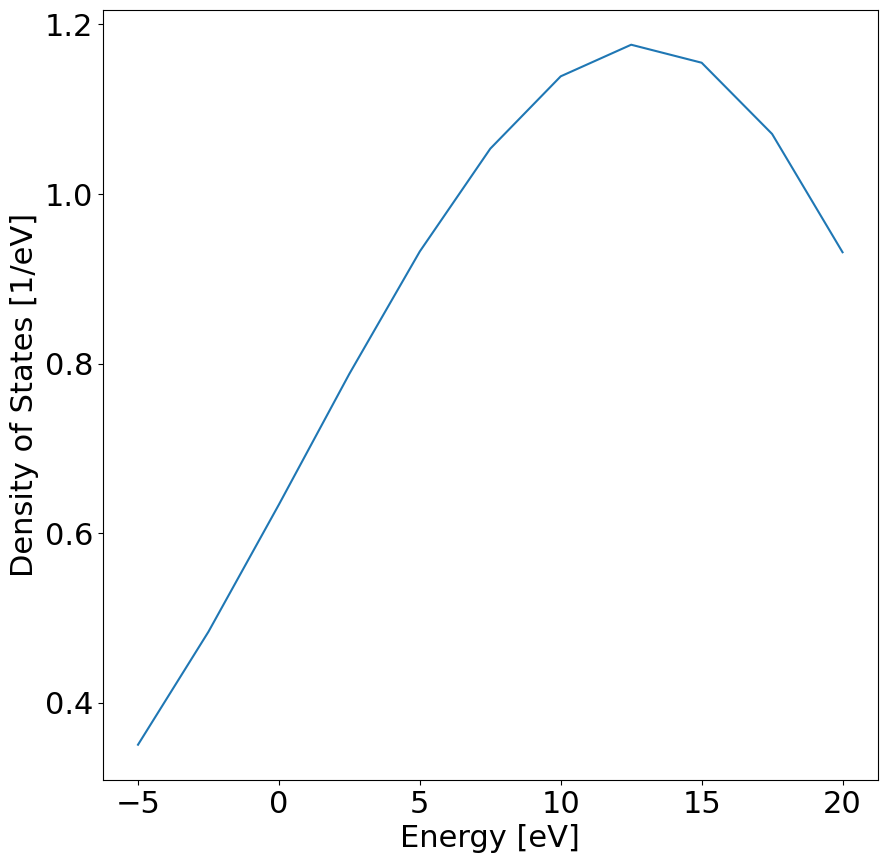

In [93]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states)

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")

print(ldos_calculator.band_energy)

Let's create load data and create the NN


In [95]:
data_handler = mala.DataHandler(parameters)
maxiter = 8
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "va")
    else:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  100,
                                  data_handler.output_dimension]

No data rescaling will be performed.
No data rescaling will be performed.
DONE ADDING DATA ITERATION 1 of 7 in 0.00s
DONE ADDING DATA ITERATION 2 of 7 in 0.00s
DONE ADDING DATA ITERATION 3 of 7 in 0.00s
DONE ADDING DATA ITERATION 4 of 7 in 0.00s
DONE ADDING DATA ITERATION 5 of 7 in 0.00s
DONE ADDING DATA ITERATION 6 of 7 in 0.00s
DONE ADDING DATA ITERATION 7 of 7 in 0.00s
DONE ADDING DATA ITERATION 8 of 7 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot1.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking targets file  Si_snapshot1.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking descriptor file  Si_snapshot2.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking targets file  Si_snapshot2.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking descriptor file  Si_snapshot3.in.npy at /content/Mala-Simulat

In [96]:
parameters.running.max_number_epochs = 10
network = mala.Network(parameters)
time1 = time.time()
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()
print(f"DONE Training Model in {time.time() - time1:.2f}s")

Initial Guess - validation data loss:  0.2675810467249967
Initial Guess - test data loss:  0.26565269187644674
Epoch 0: validation data loss: 6.760761086906902e-05
Epoch 1: validation data loss: 3.9508504531434936e-05
Epoch 2: validation data loss: 3.0300729388252553e-05
Epoch 3: validation data loss: 2.56262170929836e-05
Epoch 4: validation data loss: 2.368800988766722e-05
Epoch 5: validation data loss: 2.2275111726683606e-05
Epoch 6: validation data loss: 2.1240974275266918e-05
Epoch 7: validation data loss: 2.110869413548429e-05
Epoch 8: validation data loss: 2.05541706630771e-05
Epoch 9: validation data loss: 1.9804148815732952e-05
Final validation data loss:  1.9804148815732952e-05
Final test data loss:  3.182312421914604e-05
DONE Training Model in 120.99s


In [97]:
data_handler.clear_data()
for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))


data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()
results

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot1.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking targets file  Si_snapshot1.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking descriptor file  Si_snapshot5.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking targets file  Si_snapshot5.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


{'band_energy': [5.86453604530206, 0.8281371219893572]}

In [98]:
trainer.save_run("Si3_model")

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot5.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking targets file  Si_snapshot5.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


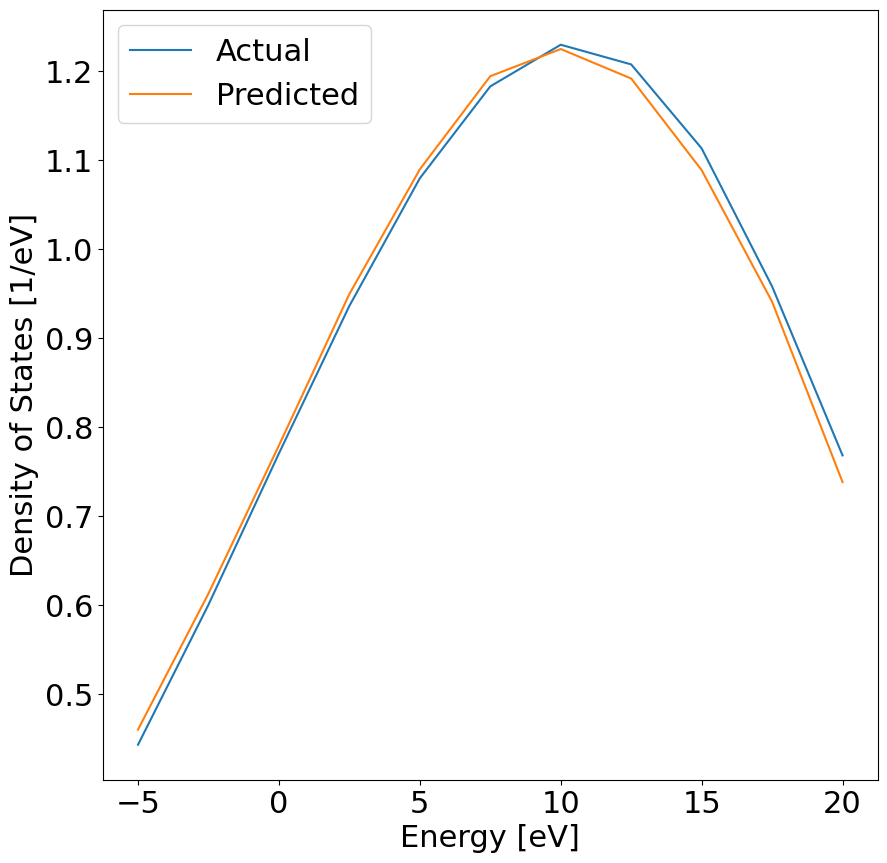

In [99]:
parameters, network, data_handler, tester = mala.Tester.load_run("Si3_model")
data_handler.clear_data()
data_handler.add_snapshot(f"Si_snapshot{test_data[0]}.in.npy", snapshot_path,
                              f"Si_snapshot{test_data[0]}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{test_data[0]}.pw.out"))
data_handler.prepare_data(reparametrize_scaler=False)
actual_ldos, predicted_ldos = tester.predict_targets(0)
ldos_calculator = data_handler.target_calculator
ldos_calculator.read_additional_calculation_data(data_handler.get_snapshot_calculation_output(0))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ldos_calculator.read_from_array(actual_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Actual")
ldos_calculator.read_from_array(predicted_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Predicted")

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")
ax.legend()


In [100]:
data_handler = mala.DataHandler(parameters)
maxiter = 8
for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "va")
    else:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()


No data rescaling will be performed.
No data rescaling will be performed.
DONE ADDING DATA ITERATION 1 of 7 in 0.00s
DONE ADDING DATA ITERATION 2 of 7 in 0.00s
DONE ADDING DATA ITERATION 3 of 7 in 0.00s
DONE ADDING DATA ITERATION 4 of 7 in 0.00s
DONE ADDING DATA ITERATION 5 of 7 in 0.00s
DONE ADDING DATA ITERATION 6 of 7 in 0.00s
DONE ADDING DATA ITERATION 7 of 7 in 0.00s
DONE ADDING DATA ITERATION 8 of 7 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot1.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking targets file  Si_snapshot1.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking descriptor file  Si_snapshot2.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking targets file  Si_snapshot2.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking descriptor file  Si_snapshot3.in.npy at /content/Mala-Simulat

In [101]:
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  500,
                                  data_handler.output_dimension]
parameters.running.early_stopping_epochs = 4
parameters.running.learning_rate = 0.6
#parameters.data.input_rescaling_type = "feature-wise-standard"

parameters.running.max_number_epochs = 10
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
time1 = time.time()
trainer.train_network()
print(f"DONE Training Model in {time.time() - time1:.2f}s")

Initial Guess - validation data loss:  0.23008518530029426
Initial Guess - test data loss:  0.2291259765625
Epoch 0: validation data loss: 3.2209600667336436e-05
Epoch 1: validation data loss: 2.375750095514421e-05
Epoch 2: validation data loss: 2.0625515557288623e-05
Epoch 3: validation data loss: 1.9382608996636613e-05
Epoch 4: validation data loss: 1.8013749998660543e-05
Epoch 5: validation data loss: 1.7815108348795266e-05
Epoch 6: validation data loss: 1.7186543506926325e-05
Epoch 7: validation data loss: 1.6758650509951177e-05
Epoch 8: validation data loss: 1.658639943580888e-05
Epoch 9: validation data loss: 1.6450421440795748e-05
Final validation data loss:  1.6450421440795748e-05
Final test data loss:  3.010619871525301e-05
DONE Training Model in 119.07s


In [102]:
parameters.targets.target_type = "LDOS"
parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5
data_handler.clear_data()
for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Si_snapshot{i}.in.npy", snapshot_path,
                              f"Si_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{i}.pw.out"))


data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()
results

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot1.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking targets file  Si_snapshot1.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking descriptor file  Si_snapshot5.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking targets file  Si_snapshot5.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


{'band_energy': [1.9432501917181852, 0.5371244526909393]}

Let's Save the file

In [103]:
trainer.save_run("Si4_model")

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Si_snapshot5.in.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
Checking targets file  Si_snapshot5.out.npy at /content/Mala-Simulations/original_QE_files/Data_Gen/Si/snapshots
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


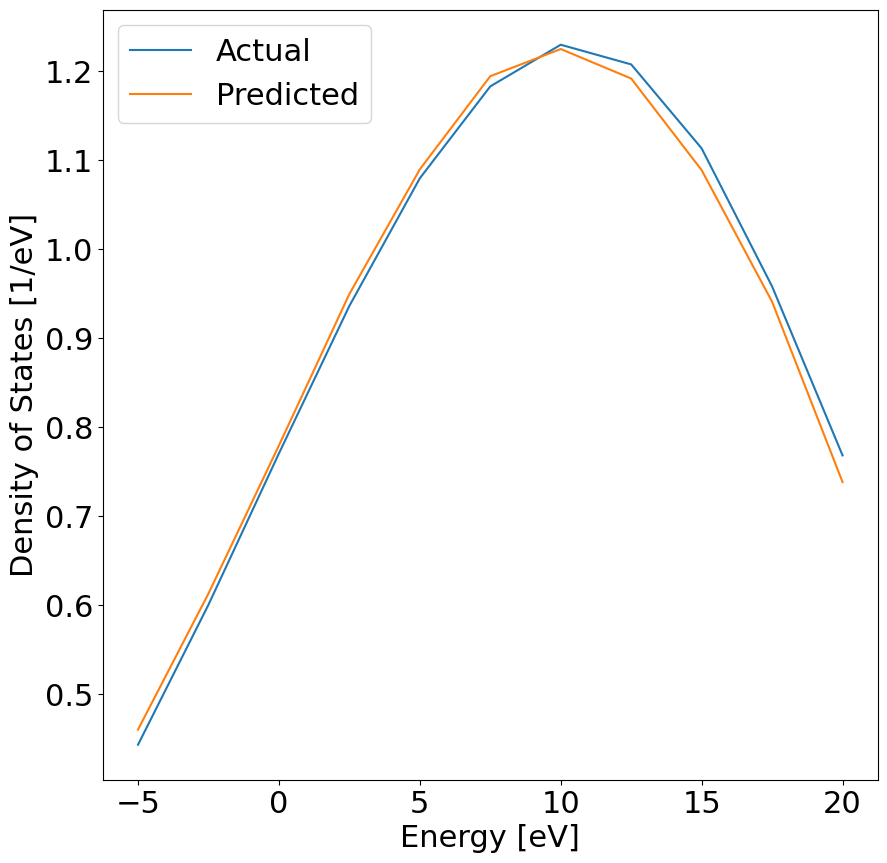

In [104]:
parameters, network, data_handler, tester = mala.Tester.load_run("Si3_model")
data_handler.clear_data()
data_handler.add_snapshot(f"Si_snapshot{test_data[0]}.in.npy", snapshot_path,
                              f"Si_snapshot{test_data[0]}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Si{test_data[0]}.pw.out"))
data_handler.prepare_data(reparametrize_scaler=False)
actual_ldos, predicted_ldos = tester.predict_targets(0)
ldos_calculator = data_handler.target_calculator
ldos_calculator.read_additional_calculation_data(data_handler.get_snapshot_calculation_output(0))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ldos_calculator.read_from_array(actual_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Actual")
ldos_calculator.read_from_array(predicted_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Predicted")

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")
ax.legend()